Run this before starting Jupyter Notebook: export LAL_DEBUG_LEVEL=4

    -Gives all EOB related error messages in terminal.

In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys

In [3]:
import matplotlib
matplotlib.__version__

'2.0.0rc1'

In [4]:
sys.path.insert(0, '../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import pycbcwaveform as pycbcwave
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(pycbcwave)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)

import constants
imp.reload(constants)
from constants import *

In [5]:
from lalwaveform import dimensionless_fd_waveform

In [6]:
import pycbc.waveform
import lalsimulation
import lal

In [7]:
#lalwaveform.print_all_approximants()
lalwaveform.print_td_approximants()
#print_fd_approximants()

0 TaylorT1
1 TaylorT2
2 TaylorT3
14 SpinTaylorT1
15 SpinTaylorT2
17 SpinTaylorT4
22 PhenSpinTaylor
23 PhenSpinTaylorRD
35 EOBNRv2
36 EOBNRv2HM
39 SEOBNRv1
40 SEOBNRv2
41 SEOBNRv2_opt
42 SEOBNRv3
43 SEOBNRv3_pert
44 SEOBNRv3_opt
45 SEOBNRv3_opt_rk4
46 SEOBNRv4
47 SEOBNRv4_opt
48 TEOBv2
49 TEOBv4
57 HGimri
58 IMRPhenomA
59 IMRPhenomB
62 IMRPhenomC
63 IMRPhenomD
65 IMRPhenomPv2
67 TaylorEt
68 TaylorT4
69 EccentricTD
73 SpinDominatedWf
74 NR_hdf5


In [8]:
# print lalsimulation.SimInspiralWaveformParamsLookupTidalLambda1(lal_params)
# print lalsimulation.SimInspiralWaveformParamsLookupTidalLambda2(lal_params)

# print lalsimulation.SimInspiralWaveformParamsLookupTidalOctupolarLambda1(lal_params)
# print lalsimulation.SimInspiralWaveformParamsLookupTidalOctupolarLambda2(lal_params)

# print lalsimulation.SimInspiralWaveformParamsLookupTidalQuadrupolarFMode1(lal_params)
# print lalsimulation.SimInspiralWaveformParamsLookupTidalQuadrupolarFMode2(lal_params)

# print lalsimulation.SimInspiralWaveformParamsLookupTidalOctupolarFMode1(lal_params)
# print lalsimulation.SimInspiralWaveformParamsLookupTidalOctupolarFMode2(lal_params)

# Testing Andrea's TEOBBNS branch

git checkout TEOBBNS

You can call 'TEOBv2' or 'TEOBv4'.

The function that is called in LALSimInspiral.c is XLALSimIMRSpinAlignedEOBWaveform

This function in LALSimIMRSpinAlignedEOB.c calculates things: XLALSimIMRSpinAlignedEOBWaveformAll

In [9]:
def spin_tidal_eob(m1, m2, s1z, s2z, lambda1, lambda2, 
                   distance, inclination, f_min, delta_t, 
                   approximant='TEOBv4', verbose=True):
    """EOB waveform with aligned spin and tidal interactions. 
    l=3 tidal interaction and l=2,3 f-mode calculated with universal relations.
    
    Parameters
    ----------
    approximant : 'TEOBv2' or 'TEOBv4'
        Based on the inspiral model given by 'SEOBNRv2' or 'SEOBNRv4'.
    
    Returns
    -------
    Waveform object
    """
    f_ref = 0.
    phiRef = 0.
    
    # Must have aligned spin
    s1x, s1y, s2x, s2y = 0., 0., 0., 0.
    
    # Eccentricity is not part of the model
    longAscNodes = 0.
    eccentricity = 0.
    meanPerAno = 0.
    
    # Set the EOB approximant
    if (approximant not in ['TEOBv2', 'TEOBv4']):
        raise Exception, "Approximant must be 'TEOBv2' or 'TEOBv4'."
    lal_approx = lalsimulation.GetApproximantFromString(approximant)
    
    
    # Calculate higher order matter effects from universal relations
    # lambda3 given in terms of lambda2
    lambda31_ur = lalsimulation.SimUniversalRelationlambda3TidalVSlambda2Tidal(lambda1)
    lambda32_ur = lalsimulation.SimUniversalRelationlambda3TidalVSlambda2Tidal(lambda2)
    # Omega2 given in terms of lambda2
    omega21_ur = lalsimulation.SimUniversalRelationomega02TidalVSlambda2Tidal(lambda1)
    omega22_ur = lalsimulation.SimUniversalRelationomega02TidalVSlambda2Tidal(lambda2)
    # Omega3 given in terms of lambda3 (not lambda2)
    omega31_ur = lalsimulation.SimUniversalRelationomega03TidalVSlambda3Tidal(lambda31_ur)
    omega32_ur = lalsimulation.SimUniversalRelationomega03TidalVSlambda3Tidal(lambda32_ur)
    
    # Insert matter parameters
    lal_params = lal.CreateDict()
    lalsimulation.SimInspiralWaveformParamsInsertTidalLambda1(lal_params, lambda1)
    lalsimulation.SimInspiralWaveformParamsInsertTidalLambda2(lal_params, lambda2)
    lalsimulation.SimInspiralWaveformParamsInsertTidalOctupolarLambda1(lal_params, lambda31_ur)
    lalsimulation.SimInspiralWaveformParamsInsertTidalOctupolarLambda2(lal_params, lambda32_ur)
    lalsimulation.SimInspiralWaveformParamsInsertTidalQuadrupolarFMode1(lal_params, omega21_ur)
    lalsimulation.SimInspiralWaveformParamsInsertTidalQuadrupolarFMode2(lal_params, omega22_ur)
    lalsimulation.SimInspiralWaveformParamsInsertTidalOctupolarFMode1(lal_params, omega31_ur)
    lalsimulation.SimInspiralWaveformParamsInsertTidalOctupolarFMode2(lal_params, omega32_ur)
    
    if verbose:
        ap = lalsimulation.GetStringFromApproximant(lal_approx)
        L2A = lalsimulation.SimInspiralWaveformParamsLookupTidalLambda1(lal_params)
        L2B = lalsimulation.SimInspiralWaveformParamsLookupTidalLambda2(lal_params)
        L3A = lalsimulation.SimInspiralWaveformParamsLookupTidalOctupolarLambda1(lal_params)
        L3B = lalsimulation.SimInspiralWaveformParamsLookupTidalOctupolarLambda2(lal_params)
        w2A = lalsimulation.SimInspiralWaveformParamsLookupTidalQuadrupolarFMode1(lal_params)
        w2B = lalsimulation.SimInspiralWaveformParamsLookupTidalQuadrupolarFMode2(lal_params)
        w3A = lalsimulation.SimInspiralWaveformParamsLookupTidalOctupolarFMode1(lal_params)
        w3B = lalsimulation.SimInspiralWaveformParamsLookupTidalOctupolarFMode2(lal_params)
        print 'Approximant: '+str(ap)
        print 'm1={:.2f}, m2={:.2f}'.format(m1, m2)
        print 's1z={:.2f}, s2z={:.2f}'.format(s1z, s2z)
        print 'delta_t={:.6f}, 1/delta_t={:.5}, f_min={:.2f}'.format(delta_t, 1./delta_t, f_min)
        print 'L2A, L2B, L3A, L3B, w2A, w2B, w3A, w3B:'
        print '{:.1f}, {:.1f}, {:.1f}, {:.1f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(L2A, L2B, L3A, L3B, w2A, w2B, w3A, w3B)
        sys.stdout.flush()
    
    # Evaluate waveform
    hp, hc = lalsimulation.SimInspiralChooseTDWaveform(
        m1*MSUN_SI, m2*MSUN_SI, 
        s1x, s1y, s1z, s2x, s2y, s2z, 
        distance*MPC_SI,
        inclination, phiRef, longAscNodes, eccentricity, meanPerAno, 
        delta_t, f_min, f_ref, lal_params, lal_approx)
    
    # Extract time array from lalsimulation's structures
    tstart = hp.epoch.gpsSeconds + hp.epoch.gpsNanoSeconds*1.0e-9
    ts = tstart + hp.deltaT*np.arange(hp.data.length)
    
    return wave.Waveform.from_hp_hc(ts, hp.data.data, hc.data.data)

In [10]:
def dimensionless_td_waveform(q=1.0, spin1z=0.0, spin2z=0.0, lambda1=0.0, lambda2=0.0,
                              mf_min=0.001, delta_tbym=10.0, **kwargs):
    """Generate dimensionless time-domain waveforms.
    Take dimensionless arguments and return dimensionless waveform.
    Spins are defined at the reference frequency which is set to mf_lower here.

    Parameters
    ----------
    q : The small mass ratio q=m2/m1<=1 where m1 >= m2.
    spin1z, lambda1 : Spins and tidal parameter of the more massive star m1.
    spin2z, lambda2 : Spins and tidal parameter of the less massive star m2.

    Returns
    -------
    h : Waveform
        Waveform in dimensionless units.
    """
    if q>1.0: raise Exception, "q must be <= 1.0."
        
    # dimensionless -> physical:
    # Pick fiducial mass2 = 1Msun and distance = 1Mpc
    mass2 = 1.0
    distance = 1.0
    inclination = 0.0
    
    mtot = mass2 * (1.0/q + 1.0)
    mass1 = mass2/q

    f_min = C_SI**3 * mf_min / (G_SI * MSUN_SI * mtot)
    delta_t = G_SI * MSUN_SI * mtot * delta_tbym / C_SI**3
    hphys = spin_tidal_eob(mass1, mass2, spin1z, spin2z, lambda1, lambda2, 
                           distance, inclination, f_min, delta_t, **kwargs)

    # # Zero the start time and phase.
    # hphys.add_x(-hphys.x[0])
    # hphys.add_phase(remove_start_phase=True)

    # physical -> dimensionless:
    return wave.physical_to_dimensionless_time(hphys, mtot, distance)

# Test EOB version with time in s and mass in $M_\odot$

Approximant: TEOBv2
m1=1.40, m2=1.40
s1z=0.00, s2z=0.00
delta_t=0.000061, 1/delta_t=1.6384e+04, f_min=200.00
L2A, L2B, L3A, L3B, w2A, w2B, w3A, w3B:
1000.0, 1000.0, 2501.0, 2501.0, 0.0642, 0.0642, 0.0876, 0.0876


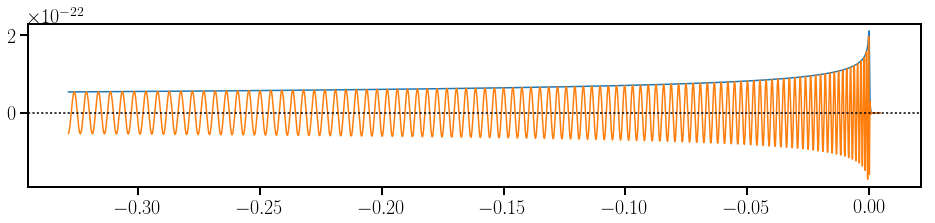

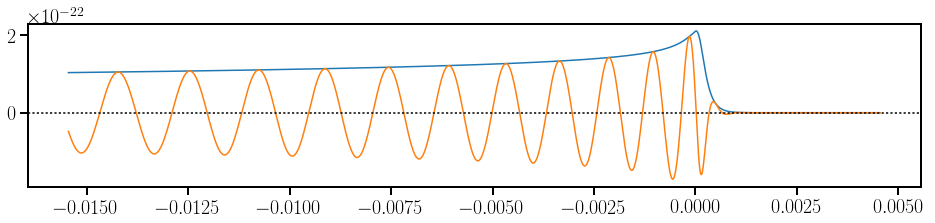

In [12]:
q = 1
m1=1.4
m2=q*m1
s1z = 0.0
s2z = 0.0
lambda1 = 1000.0
lambda2 = 1000.0
distance = 100.
inclination = 0.
f_min = 200.
delta_t = 1./2**14
approximant = 'TEOBv2'
h1 = spin_tidal_eob(m1, m2, s1z, s2z, lambda1, lambda2, 
               distance, inclination, f_min, delta_t, 
               approximant=approximant)

fig, axes = wave.plot_waveforms([h1], npoints=10000)
fig, axes = wave.plot_waveforms([h1], xi=h1.x[-1]-0.020, npoints=10000)

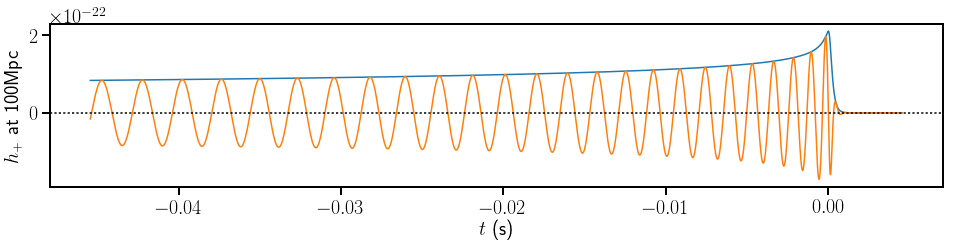

In [15]:
fig, axes = wave.plot_waveforms([h1], xi=h1.x[-1]-0.050, npoints=10000)
axes.set_xlabel(r'$t$ (s)')
axes.set_ylabel(r'$h_+$ at 100Mpc')

# Check that using fixed q but different m1, m2 doesn't effect dimensionless waveform

In [ ]:
q = 0.5
s1z = 0.1
s2z = 0.4
lambda1 = 100.0
lambda2 = 1000.0
distance = 100.
inclination = 0.
mf_min = 0.005
delta_tbym = 10.0
approximant = 'TEOBv2'


m1 = 2.0
m2 = q*m1
mtot = m1 + m2
f_min = C_SI**3 * mf_min / (G_SI * MSUN_SI * mtot)
delta_t = G_SI * MSUN_SI * mtot * delta_tbym / C_SI**3
h1 = spin_tidal_eob(m1, m2, s1z, s2z, lambda1, lambda2, 
               distance, inclination, f_min, delta_t, 
               approximant=approximant)
h1dim = wave.physical_to_dimensionless_time(h1, mtot, distance)


m1 = 3.0
m2 = q*m1
mtot = m1 + m2
f_min = C_SI**3 * mf_min / (G_SI * MSUN_SI * mtot)
delta_t = G_SI * MSUN_SI * mtot * delta_tbym / C_SI**3
h2 = spin_tidal_eob(m1, m2, s1z, s2z, lambda1, lambda2, 
               distance, inclination, f_min, delta_t, 
               approximant=approximant)
h2dim = wave.physical_to_dimensionless_time(h2, mtot, distance)


h3dim = dimensionless_td_waveform(q=q, spin1z=s1z, spin2z=s2z, 
                                 lambda1=lambda1, lambda2=lambda2, 
                                 mf_min=mf_min, delta_tbym=delta_tbym, 
                                 approximant=approximant, verbose=True)

In [ ]:
fig, axes = wave.plot_waveforms([h1dim], npoints=10000)
fig, axes = wave.plot_waveforms([h2dim], npoints=10000)
fig, axes = wave.plot_waveforms([h3dim], npoints=10000)

fig, axes = wave.plot_waveforms([h1dim, h2dim], xi=-1000, npoints=10000)
fig, axes = wave.plot_waveforms([h2dim, h3dim], xi=-1000, npoints=10000)

# Test the $2^5$ corners of parameter space

In [11]:
def uniform_grid(n, limits):
    """This is really stupid.
    """
    points = []
    for i in range(n):
        xmin, xmax = limits[0, 0], limits[0, 1]
        x0 = np.linspace(xmin, xmax, n)
        for j in range(n):
            xmin, xmax = limits[1, 0], limits[1, 1]
            x1 = np.linspace(xmin, xmax, n)
            for k in range(n):
                xmin, xmax = limits[2, 0], limits[2, 1]
                x2 = np.linspace(xmin, xmax, n)
                for l in range(n):
                    xmin, xmax = limits[3, 0], limits[3, 1]
                    x3 = np.linspace(xmin, xmax, n)
                    for m in range(n):
                        xmin, xmax = limits[4, 0], limits[4, 1]
                        x4 = np.linspace(xmin, xmax, n)
                        
                        point = [x0[i], x1[j], x2[k], x3[l], x4[m]]
                        #print point
                        points.append(point)
    #print points
    return np.array(points)

In [12]:
# Parameters for the training set
limits = np.array([[1.0/2.0, 1.0], [-0.4, 0.4], [-0.4, 0.4], [1000, 2000], [1000, 2000]])
corners = uniform_grid(2, limits)

In [17]:
corners[:, 4]

array([ 1000.,  2000.,  1000.,  2000.,  1000.,  2000.,  1000.,  2000.,
        1000.,  2000.,  1000.,  2000.,  1000.,  2000.,  1000.,  2000.,
        1000.,  2000.,  1000.,  2000.,  1000.,  2000.,  1000.,  2000.,
        1000.,  2000.,  1000.,  2000.,  1000.,  2000.,  1000.,  2000.])

In [13]:
mf_min = 0.005
delta_tbym = 10.0
approximant = 'TEOBv2'

h_list = []
for p in corners:
    print p
    q, s1, s2, lambda1, lambda2 = p

    hdim = dimensionless_td_waveform(q=q, spin1z=s1, spin2z=s2, 
                                 lambda1=lambda1, lambda2=lambda2, 
                                 mf_min=mf_min, delta_tbym=delta_tbym, 
                                 approximant=approximant)
    h_list.append(hdim)
    #fig, axes = wave.plot_waveforms(h_list, npoints=10000)

[  5.00000000e-01  -4.00000000e-01  -4.00000000e-01   1.00000000e+03
   1.00000000e+03]
Approximant: TEOBv2
m1=2.00, m2=1.00
s1z=-0.40, s2z=-0.40
delta_t=0.000148, 1/delta_t=6767.5, f_min=338.38
L2A, L2B, L3A, L3B, w2A, w2B, w3A, w3B:
1000.0, 1000.0, 2501.0, 2501.0, 0.0642, 0.0642, 0.0876, 0.0876
[  5.00000000e-01  -4.00000000e-01  -4.00000000e-01   1.00000000e+03
   2.00000000e+03]
Approximant: TEOBv2
m1=2.00, m2=1.00
s1z=-0.40, s2z=-0.40
delta_t=0.000148, 1/delta_t=6767.5, f_min=338.38
L2A, L2B, L3A, L3B, w2A, w2B, w3A, w3B:
1000.0, 2000.0, 2501.0, 6490.1, 0.0642, 0.0546, 0.0876, 0.0749
[  5.00000000e-01  -4.00000000e-01  -4.00000000e-01   2.00000000e+03
   1.00000000e+03]
Approximant: TEOBv2
m1=2.00, m2=1.00
s1z=-0.40, s2z=-0.40
delta_t=0.000148, 1/delta_t=6767.5, f_min=338.38
L2A, L2B, L3A, L3B, w2A, w2B, w3A, w3B:
2000.0, 1000.0, 6490.1, 2501.0, 0.0546, 0.0642, 0.0749, 0.0876
[  5.00000000e-01  -4.00000000e-01  -4.00000000e-01   2.00000000e+03
   2.00000000e+03]
Approximant: TEOBv

RuntimeError: Generic failure

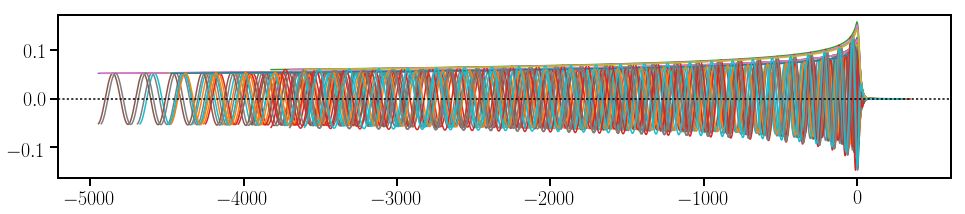

In [14]:
fig, axes = wave.plot_waveforms(h_list, npoints=10000)

# Compare TEOBv2 to TEOBv4

In [ ]:
q = 1.0/3.0
s1z = -0.7
s2z = -0.7
lambda1 = 100.0
lambda2 = 100.0
mf_min = 0.008
delta_tbym = 10.0

approximant = 'TEOBv2'
hdim1 = dimensionless_td_waveform(q=q, spin1z=s1z, spin2z=s2z, 
                                 lambda1=lambda1, lambda2=lambda2, 
                                 mf_min=mf_min, delta_tbym=delta_tbym, 
                                 approximant=approximant)

approximant = 'TEOBv4'
hdim2 = dimensionless_td_waveform(q=q, spin1z=s1z, spin2z=s2z, 
                                 lambda1=lambda1, lambda2=lambda2, 
                                 mf_min=mf_min, delta_tbym=delta_tbym, 
                                 approximant=approximant)

fig, axes = wave.plot_waveforms([hdim1, hdim2], npoints=10000)

# Align at initial conditions instead of at max frequency of Hamiltonian (or amplitude?)
hdim1.add_x(-hdim1.x[0])
hdim1.add_phase(remove_start_phase=True)
hdim2.add_x(-hdim2.x[0])
hdim2.add_phase(remove_start_phase=True)
fig, axes = wave.plot_waveforms([hdim1, hdim2], npoints=10000)

# Test universal relations

In [ ]:
lambda2 = np.logspace(-2, 5, 51)

lambda3 = [lalsimulation.SimUniversalRelationlambda3TidalVSlambda2Tidal(l2) for l2 in lambda2]
fig, axes = plt.subplots(figsize=(8, 3))
axes.plot(lambda2, lambda3)
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel(r'$\Lambda_2$')
axes.set_ylabel(r'$\Lambda_3$')

omega2 = [lalsimulation.SimUniversalRelationomega02TidalVSlambda2Tidal(l2) for l2 in lambda2]
fig, axes = plt.subplots(figsize=(8, 3))
axes.plot(lambda2, omega2)
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel(r'$\Lambda_2$')
axes.set_ylabel(r'$\omega_2$')

omega3 = [lalsimulation.SimUniversalRelationomega03TidalVSlambda3Tidal(l3) for l3 in lambda3]
fig, axes = plt.subplots(figsize=(8, 3))
axes.plot(lambda3, omega3)
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel(r'$\Lambda_3$')
axes.set_ylabel(r'$\omega_3$')

fig, axes = plt.subplots(figsize=(8, 3))
axes.plot(lambda2, omega3)
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel(r'$\Lambda_2$')
axes.set_ylabel(r'$\omega_3$')

In [ ]:
lambda3 = [lalsimulation.SimUniversalRelationlambda3TidalVSlambda2Tidal(l2) for l2 in lambda2]
fig, axes = plt.subplots(figsize=(8, 3))
axes.plot(np.log(lambda2), np.log(lambda3))
axes.set_xlim(0, 9)
axes.set_xlabel(r'$\ln\Lambda_2$')
axes.set_ylabel(r'$\ln\Lambda_3$')

omega2 = [lalsimulation.SimUniversalRelationomega02TidalVSlambda2Tidal(l2) for l2 in lambda2]
fig, axes = plt.subplots(figsize=(8, 3))
axes.plot(np.log(lambda2), omega2)
axes.set_xlim(0, 9)
axes.set_ylim(0, 0.35)
axes.set_xlabel(r'$\ln\Lambda_2$')
axes.set_ylabel(r'$\omega_2$')

omega3 = [lalsimulation.SimUniversalRelationomega03TidalVSlambda3Tidal(l3) for l3 in lambda3]
fig, axes = plt.subplots(figsize=(8, 3))
axes.plot(np.log(lambda3), omega3)
axes.set_xlim(0, 9)
axes.set_xlabel(r'$\ln\Lambda_3$')
axes.set_ylabel(r'$\omega_3$')

fig, axes = plt.subplots(figsize=(8, 3))
axes.plot(np.log(lambda2), omega3)
axes.set_xlim(0, 9)
axes.set_ylim(0, 0.35)
axes.set_xlabel(r'$\ln\Lambda_2$')
axes.set_ylabel(r'$\omega_3$')

# Make training set

In [ ]:


def td_waveform_to_conditioned_fd_waveform_difference_with_fd(
    f_min, delta_t,
    winon_i, winon_f, winoff_i, winoff_f,
    n_ext,
    trunc_i, trunc_f, ref_delta_f, npoints=10000,
    win='planck', f_coalescence=None, remove_start_phase=True,
    approximant='TEOBv2',
    q=1.0,
    spin1x=0.0, spin1y=0.0, spin1z=0.0,
    spin2x=0.0, spin2y=0.0, spin2z=0.0,
    lambda1=0.0, lambda2=0.0):
    """Generate a time-domain waveform, then condition and Fourier transform it.
    Then subtract a frequency-damain reference waveform.
    """
    h = dimensionless_td_waveform(q=q, 
                                  spin1z=spin1z, spin2z=spin2z, 
                                  lambda1=lambda1, lambda2=lambda2, 
                                  mf_min=f_min, delta_tbym=delta_t, 
                                  approximant=approximant)

    h_cond = train.condition_waveform(h,
                winon_i, winon_f, winoff_i, winoff_f,
                n_ext,
                trunc_i, trunc_f, npoints=npoints,
                win=win, f_coalescence=f_coalescence, remove_start_phase=remove_start_phase)
    
    dt_insp = -t_start
    h_cond.phase += 2.*np.pi*h_tilde.x*dt_insp
    
    # Generate FD wavefrom between trunc_i and trunc_f with same parameters
    h_ref = dimensionless_fd_waveform(approximant='TaylorF2',
                q=q,
                spin1x=spin1x, spin1y=spin1y, spin1z=spin1z,
                spin2x=spin2x, spin2y=spin2y, spin2z=spin2z,
                lambda1=lambda1, lambda2=lambda2,
                mf_min=trunc_i, mf_max=trunc_f, delta_mf=ref_delta_f)

    wave.resample_uniform(h_ref, npoints=npoints, spacing='log', order=2)

    h_ref.add_phase(remove_start_phase=remove_start_phase)

    dh = train.lnamp_phase_difference(h_cond, h_ref, npoints=npoints, spacing='log', order=2)
    return h_cond, dh

In [ ]:
########################################################
#     The parameters to be used for all waveforms      #
########################################################

f_min = 0.0049
delta_t = 10.0
approximant = 'TEOBv2'
amp_ord = 0

min_total_time = 4.0*train.zero_pn_coalescence_time(f_min, 1.0)
n_ext = train.next_pow_2(min_total_time, delta_t)
print min_total_time, n_ext

winon_i = 0.005
winon_f = 0.006
winoff_i = 0.022
winoff_f = 0.023
trunc_i = winon_f
trunc_f = 0.03
npoints = 10000
win = 'planck'
#f_coalescence = winoff_f

ref_delta_f = 1.0e-8

In [ ]:
q = 1.0/3.0
spin1z = 0.2
spin2z = -0.2
lambda1 = 1000.0
lambda2 = 2000.0

h, dh = td_waveform_to_conditioned_fd_waveform_difference_with_fd(
    f_min, delta_t,
    winon_i, winon_f, winoff_i, winoff_f,
    n_ext,
    trunc_i, trunc_f, ref_delta_f, npoints=npoints,
    win=win, f_coalescence=None, remove_start_phase=True,
    approximant=approximant,
    q=q,
    spin1z=spin1z, spin2z=spin2z,
    lambda1=lambda1, lambda2=lambda2)

In [ ]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([h])
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

fig, (ax1, ax2) = wave.plot_waveforms_fd([dh])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()